# Capstone Project 1 Milestone Report

This file presents an overview of all work that has been done toward the capstone project thus far.

Throughout the document, code is excluded for clarity of narrative.  For coding details please refer back to the files Data_Wrangling.ipynb, Storytelling.ipynb, and Inferential_Statistics.ipynb.

## Define the Problem

The original statement of the problem can be found on Kaggle:

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification.

Walmart has put forth a data set consisting of customer transactional data, both purchases and returns, with the goal of identifying the type of trip each customer made.  While explicit descriptions of each of the 38 possible trip types are not given, sample ones include weekly groceries, monthly prescriptions, holiday shopping, party, and an "other" category.

With so many categories and shoppers have such diverse carts, it seems unlikely that any predictive model will be able to correctly identify trips with an extremely high degree of accuracy.  Rather, it is more useful to predict the probability that a given trip fits into any one of the possible categories.  This is also more useful for further analysis, as there may be a degree of overlap between trip types.  Therefore, the specific goal is to minimize the log likelihood loss function on the training data.

## Identify Your Client

By creating such a segmentation, Walmart can better understand why its customers choose to shop there.  For instance, while Walmart is not generally known for being a grocery store, a large proportion of transactions being of that type could indicate that profits could be increased by growing the groceries department.  Another possibility is that these classifications may result in certain surprising products often being purchased together, such as the famous diapers and beer example.  This could suggest strategic placement of products in relation to each other in order to entice shoppers into making purchases they did not originally intend to make.  More generally, the data could be used as a variable in a market basket analysis recommendation system based on what type of trip a given item most frequently appears in.

## Describe Your Data Set and How You Cleaned/Wrangled It

### Features

The data is presented as a unique record for each unique item involved in a transaction.  There are six variables:

- visit number: an integer assigned to items purchased at a single checkout
- weekday: the day of the week the transaction occured
- unique product code (upc): the unique number assigned to a product that 
- scan count: the quanity of the product purchased (negative if returned)
- department description: a short description of the department Walmart lists the product in
- fineline number: a number used to make a sharper division than departments

Note that this implies that full transaction for a single customer entails multiple records, namely all records with the same visit number.  Together, these variables are used to predict trip type.

Below is a sample of what the data looks like.

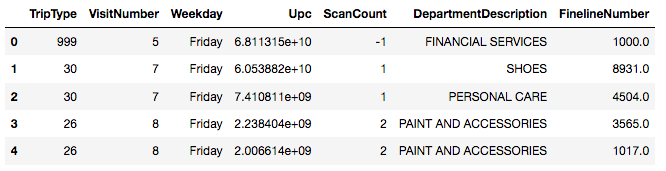

In [1]:
from IPython.display import Image
Image('df_head.png')

All of the variables are categorical with the exception of scan count.  However, they were all originally stored as integers.  The data types were all converted to categoricals in order to save memory space and improve efficiency.  The expection to this was upc because there were too many of them for the conversion to be beneficial.

### Missing Values

There are a few missing values for upc, department description, and fineline number.  UPC has a missing value if and only if fineline number has a missing value, and the department description is missing only if the former two are missing.  Fortunately, this scenario occurs for few enough transactions that they can easily be removed without having an adverse affect on the data.

Another option was to assign a single new categorical variable value to each feature of each record of the same missing data type.  That is, assign all records missing UPC and fineline to have the same UPC and fineline values, and assign all records missing UPC, fineline, and department description to have the same UPC, fineline, and department description values (but different UPC and fineline values from the scenario where department description is not missing).

### Feature Engineering

The scan count was broken into two variables: one for the purchase count and one for the return count.  This was done because I feel that these are fundamentally different actions and a simple negative value does not sufficiently capture that aspect.

The last step in the wrangling was to group all of the data by visit number, as each individual record with the same visit number come from a single customer transaction.  This entire transaction is what is being assigned a trip type, and as such each record for that visit number should be grouped together, used to predict, and assigned the same trip type.

## List Other Potential Data Sets You Could Use

### External Sources

This data would be the most useful if it were joined with another table that listed customer IDs for each visit number.  Such data would likely only be available for customers who are members at Walmart and scan their card at checkout.  Without this, there is no identifying record of recurring customers; certainly tracking cannot be done on a cash transaction, and it is unlikely that Walmart would be allowed to utilize information from a credit card transaction for security reasons.  Equipped with this information, Walmart could then track trip types per member over time to better understand why that particular customer shops at Walmart.  Marketing could then use this information in order to craft targeted coupons or flyers to sway the customer to shop more often and make more purchases.

### Internal Sources

One way to view additional data sets is that they are a source of more information.  Much more information can also be gleamed, however, from the data we already have.  Significant feature engineering could be explored, such as total number of items purchased, total number of items purchased per department, department with the most items purchased, the maximum quantity of a single item purchased, etc.  The goal of this project is not to delve into the intricate world of feature engineerings, so these options wil not be further explored.

## Explain Your Initial Findings

### Histograms

An intial plot of the frequencies of the different trip types shows that trip types 40 and 39 account for the vast majority of all trips.

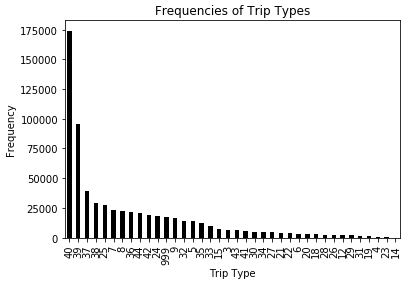

In [2]:
Image('trip_type_hist_1.png')

However, this data is skewed, as it actually counts the total number of unique upcs per unique visit number for a given trip type.  Instead plotting a histogram of frequency of trip type based solely on unique visit number yields a much less skewed result.

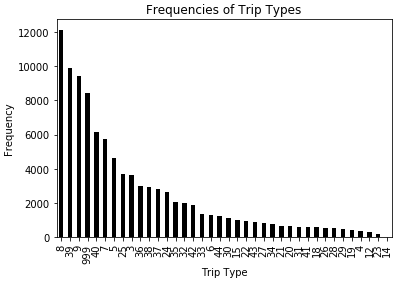

In [3]:
Image('trip_type_hist_2.png')

In fact, trip type 8 occurs the most often at roughly 12,000 times.  In the initial graph, trip type 8 occured 25,000 times.  What this means is that on average customers bought roughly two unique items for trip type 8.  Compare this to trip type 40 where customers averaged nearly 30 unique items.

Naively, one would hope that departments form a good high-level variable for predicting trip type.  Let's see the histogram of how often a unique item from a department is purchased.

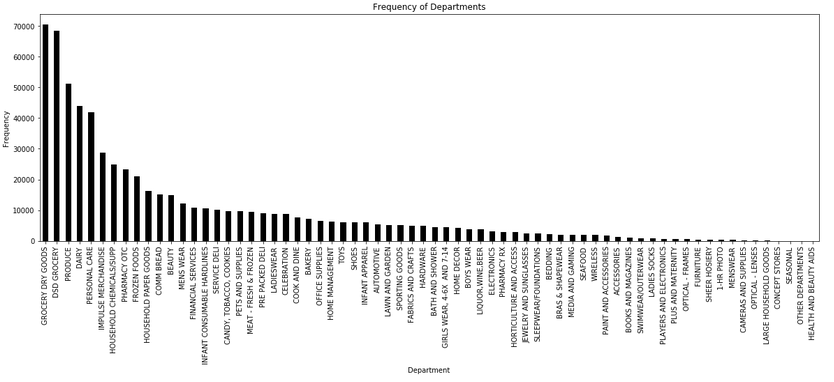

In [4]:
Image('department_hist.png')

The CDFs of fineline numbers and upcs both show that there are a few significant outliers in terms of frequency.  Of the 647,054 unique products per unique transaction, one fineline number occurs a staggering 561,489 times (the average is 125 times) and one of the upcs occurs 7,657 times (the average is 7 times).

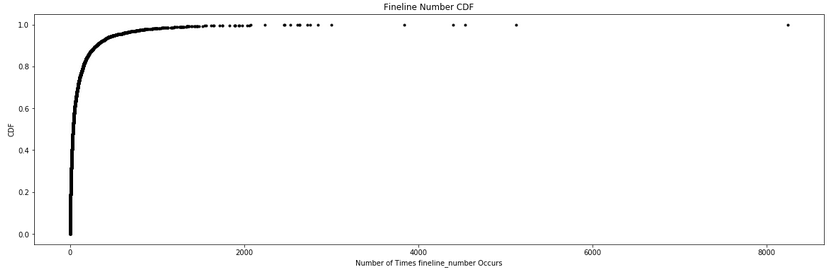

In [5]:
Image('fineline_cdf.png')

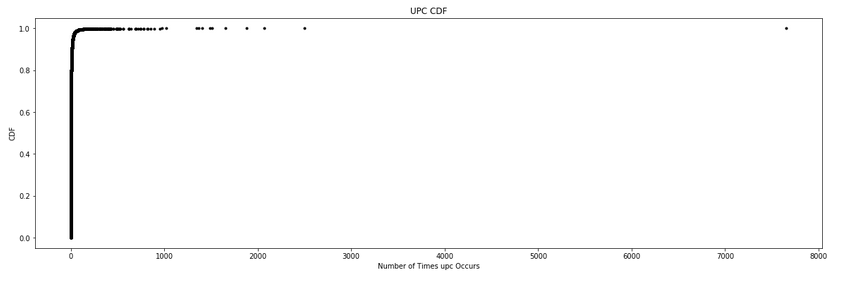

In [6]:
Image('upc_cdf.png')

### Statistics

Because the vast majority of the data is categorical and we have not performed any feature engineering to derive numeric variables, our statistics are largely limited to methods involving counting frequencies.  To this end, chi squared is the most commonly used statistic.  It is used to derive a p-value use potentially reject a null hypothesis regarding the distribution of the data.  If it does reject the null hypothesis, it does not help in giving an indication of what the actual distribution is.

The statistic can be used to measure the confidence in the distribution of a single feature or to compare the distributions of two features.  In the latter case, we are measuring whether the distribution of one feature changes given the value of another feature, i.e. whether two variables are independent.

The difficulty with this data set is that there is not a clear prior distribution to test for any one of the features in hopes of it not being rejected.  For instance, assume that customers shop equally often on every day of the week.  We obtain the below results.

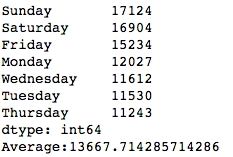

In [7]:
Image('daily_totals.png')

In [8]:
Image('daily_chi_square.png')

Obtaining a p-value of 0.0 means that we can reject the null hypothesis that customers shop equally often throughout the week.  However, how is that helpful in predicting trip type?  Let's try instead seeing whether day of the week and trip type are independent of each other.

In [9]:
Image('day_and_type_chi_square.png')

Again we get a p-value of 0.0.  This is good because we do not want predictor variables and output variables to be independent; otherwise the predictor variable would be useless.  However, it does not give us any insight into how the two are related.  That part will have to be determined by a machine learning model.

## Deeper Dive

While this data set appears quite clean and friendly, it is potentially constrained by how few varaibles it has.  A simple logistic regression model can still be trained on this data as it is, but the model is unlikely to perform exceedingly well.  A more robust and accurate model would require far more feature engineering than simply separating the scan count into purchases and returns.  A few potential new fields include total purchase count, returns as a binary variable, most promiment department based on both unique items and total item count, and the item distribution over the departments per order.  For further imporvement, it is also possible that there could be a way to exploid the semi-hierarchical structure between upcs, fineline numbers, and department descriptions.  Departments like "MENSWEAR" and "MENS WEAR" could also be merged.